# Electrum Network Topology Overview

This notebook analyzes the topology of the Electrum server network based on the collected data. It covers server reachability, software diversity, geographic distribution, latency, and infrastructure concentration, as outlined in the project documentation.

## 1. Setup

In [1]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import geoip2.database
import re

# --- Setup ---
DATA_DIR = Path("../../data")
sns.set_theme(style="whitegrid")

# --- Load Datasets ---
def load_json_df(file_path):
    try:
        with open(file_path, "r") as f:
            return pd.DataFrame(json.load(f))
    except FileNotFoundError:
        print(f"Warning: {file_path} not found.")
        return pd.DataFrame()

peers_df = load_json_df(DATA_DIR / "peers/peers.json")
online_peers_df = load_json_df(DATA_DIR / "online_peers/online_peers.json")
tls_certs_df = load_json_df(DATA_DIR / "tls_certs/tls_certs.json")
fingerprints_df = load_json_df(DATA_DIR / "fingerprints/fingerprints.json")
tls_clusters_df = load_json_df(DATA_DIR / "tls_clusters/tls_clusters_fingerprint.json")

## 2. Server Count & Reachability

We first examine the availability and connection capabilities of all peers discovered during the crawl.

Total discovered peers: 3828
Total online (reachable) peers: 1665

Breakdown by protocol:
- Reachable SSL servers: 328
- Reachable TCP servers: 1337


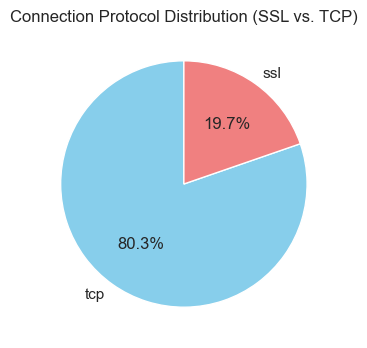

In [2]:
if not online_peers_df.empty:
    protocol_counts = online_peers_df['protocol'].value_counts()
    
    print(f"Total discovered peers: {len(peers_df)}")
    print(f"Total online (reachable) peers: {len(online_peers_df)}")
    print("\nBreakdown by protocol:")
    print(f"- Reachable SSL servers: {protocol_counts.get('ssl', 0)}")
    print(f"- Reachable TCP servers: {protocol_counts.get('tcp', 0)}")

    plt.figure(figsize=(6, 4))
    protocol_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    plt.title('Connection Protocol Distribution (SSL vs. TCP)')
    plt.ylabel('')
    plt.show()

## 3. Geographic Distribution

Understanding where Electrum servers are physically and logically located is crucial for assessing the decentralization and resilience of the network. By performing GeoIP lookups on all reachable peers, we can aproximate their placement and map how sercer capacity is distributed across countries and regions. This allows us to identify areas with high server density, highlight potential geographic centralization, and detect clusters that may be operated from the same environment.

Analyzing the network by ISP and Autonomous System Number (ASN) provides deeper view into the underlying infrasctructure. ASN analysis reveals which hosting providers dominate the network, helping us pinpoint large cloud clusters, identify operators running many servers from a single provider and detect potential single-operator control.

In [3]:
# Note: To run GeoIP analysis, download the GeoLite2-Country.mmdb and GeoLite2-ASN.mmdb databases from MaxMind.
GEOIP_COUNTRY_DB = '../../GeoLite2-Country.mmdb'
GEOIP_ASN_DB = '../../GeoLite2-ASN.mmdb'

# --- Per-Country Server Density ---
if Path(GEOIP_COUNTRY_DB).exists() and not online_peers_df.empty:
    with geoip2.database.Reader(GEOIP_COUNTRY_DB) as reader:
        def get_country(ip):
            try: return reader.country(ip).country.name
            except: return 'Unknown'
        online_peers_df['country'] = online_peers_df['host'].apply(get_country)
    
    country_counts = online_peers_df['country'].value_counts().head(15)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, palette='viridis', legend=False)
    plt.title('Top 15 Countries Hosting Electrum Servers')
    plt.xlabel('Number of Servers')
    plt.ylabel('Country')
    plt.show()
else:
    print(f"GeoIP Country database not found at '{GEOIP_COUNTRY_DB}'. Skipping country analysis.")

# --- ISP/ASN Breakdown ---
if Path(GEOIP_ASN_DB).exists() and not online_peers_df.empty:
    with geoip2.database.Reader(GEOIP_ASN_DB) as reader:
        def get_asn(ip):
            try: return reader.asn(ip).autonomous_system_organization
            except: return 'Unknown'
        online_peers_df['asn'] = online_peers_df['host'].apply(get_asn)

    asn_counts = online_peers_df['asn'].value_counts().head(15)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=asn_counts.values, y=asn_counts.index, hue=asn_counts.index, palette='plasma', legend=False)
    plt.title('Top 15 ISPs/ASNs Hosting Electrum Servers')
    plt.xlabel('Number of Servers')
    plt.ylabel('ISP / Autonomous System')
    plt.show()
else:
    print(f"GeoIP ASN database not found at '{GEOIP_ASN_DB}'. Skipping ASN analysis.")

GeoIP Country database not found at '../../GeoLite2-Country.mmdb'. Skipping country analysis.
GeoIP ASN database not found at '../../GeoLite2-ASN.mmdb'. Skipping ASN analysis.


## 4. Infrastructure Concetration

To identify which server are likely controlled by the same underlying operator, we applied a clustering technique based on SSL certificate fingerprints. Because Electrum servers typically use self-signed certificates, the certificate metadata and fingerprint act as a stong behavioral signature of the entity running the server. When multipleservers present the same certificate fingerprint we can reliably infer common operator ownership. 

Found 21 clusters of servers reusing the same TLS certificate.
These clusters contain a total of 327 servers.
99.70% of servers with TLS certificate are part of a cluster.

Top 10 largest certificate clusters:


,count,issuer,subject
11,20,None,None
16,20,None,None
13,20,None,None
14,20,None,None
15,19,None,None
2,19,None,None
3,19,None,None
6,19,None,None
9,19,None,None
1,19,None,None


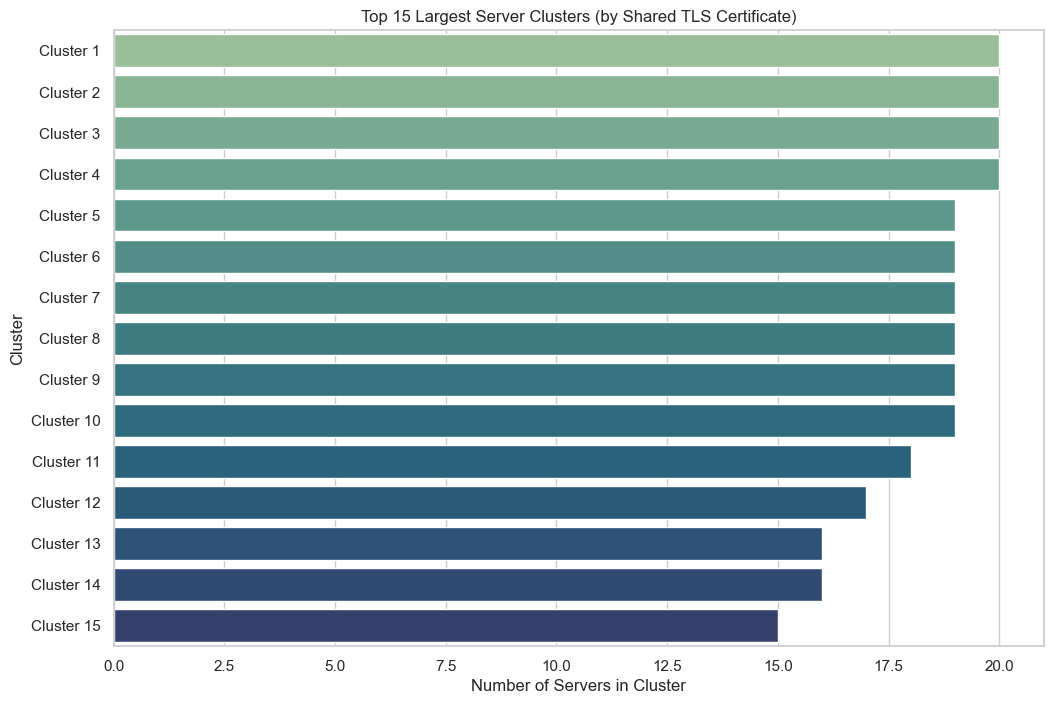

In [4]:
if not tls_clusters_df.empty:
    # Filter for clusters with more than one server
   reused_cert_clusters = tls_clusters_df[tls_clusters_df['count'] > 1].sort_values(by='count', ascending=False)
    
   num_clusters = len(reused_cert_clusters)
   num_servers_in_clusters = reused_cert_clusters['count'].sum()
    
   print(f"Found {num_clusters} clusters of servers reusing the same TLS certificate.")
   print(f"These clusters contain a total of {num_servers_in_clusters} servers.")

   if num_clusters > 0:

      if not tls_certs_df.empty:
         percentage_in_clusters = (num_servers_in_clusters / len(tls_certs_df)) * 100
         print(f"{percentage_in_clusters:.2f}% of servers with TLS certificate are part of a cluster.")
         
         # Display the top 10 largest clusters
         print("\nTop 10 largest certificate clusters:")
         display(reused_cert_clusters[['count', 'issuer','subject']].head(10))
         # Plot the size of the top 15 clusters
         plt.figure(figsize=(12, 8))
         top_15_clusters = reused_cert_clusters.head(15)
         sns.barplot(x=top_15_clusters['count'], y=[f"Cluster {i+1}" for i in range(len(top_15_clusters))], hue=[f"Cluster {i+1}" for i
            in range(len(top_15_clusters))], palette='crest', legend=False)
         plt.title('Top 15 Largest Server Clusters (by Shared TLS Certificate)')
         plt.xlabel('Number of Servers in Cluster')
         plt.ylabel('Cluster')
         plt.show()

## 5. Software Diversity

Analyzing the software diversity of reachable Electrum server provides insights into the heterogeneity, security posture, and descentralization of the network's implementation laye.

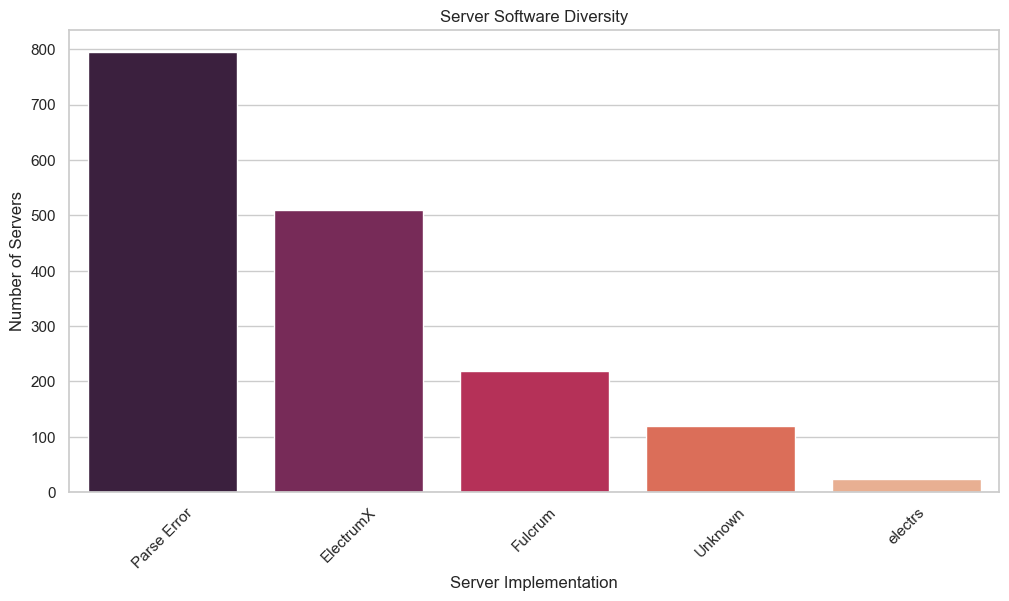

In [5]:
def parse_version(raw_version):
    try:
        data = json.loads(raw_version)
        result = data.get('result')
        if not result: return 'Unknown'
        server_str = str(result[0]) if isinstance(result, list) else str(result)
        
        if 'ElectrumX' in server_str: return 'ElectrumX'
        if 'electrs' in server_str: return 'electrs'
        if 'Fulcrum' in server_str: return 'Fulcrum'
        
        match = re.match(r'([a-zA-Z\s]+)', server_str)
        return match.group(1).strip() if match else 'Unknown'
    except:
        return 'Parse Error'

def parse_version(raw_version):
    try:
        data = json.loads(raw_version)
        result = data.get('result')
        if not result: return 'Unknown'
        server_str = str(result[0]) if isinstance(result, list) else str(result)
        
        if 'ElectrumX' in server_str: return 'ElectrumX'
        if 'electrs' in server_str: return 'electrs'
        if 'Fulcrum' in server_str: return 'Fulcrum'
        
        match = re.match(r'([a-zA-Z\s]+)', server_str)
        return match.group(1).strip() if match else 'Unknown'
    except:
        return 'Parse Error'

if not online_peers_df.empty:
    online_peers_df['server_name'] = online_peers_df['version_raw'].apply(parse_version)
    server_counts = online_peers_df['server_name'].value_counts()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=server_counts.index, y=server_counts.values, hue=server_counts.index, palette='rocket', legend=False)
    plt.title('Server Software Diversity')
    plt.xlabel('Server Implementation')
    plt.ylabel('Number of Servers')
    plt.xticks(rotation=45)
    plt.show()

## 6. Latency Graph

Latency measurements offer an additional behavioral perspective on the Electrum network by capturing how quickly each server responds to client requests. Because network latency is strongly influenced by physical distance, routing paths, and hosting environment, plotting these values helps us infer geographic proximity, identify clusters of servers that share similar infrastructure, and detect patterns consistent with load-balanced or replicated deployments. Servers that exhibit nearly identical latency profiles are likely hosted in the same datacenter or controlled by the same operator, while anomalously low or uniform latencies may indicate front-end load balancers masking multiple backend servers. By analyzing latency distributions and cluster formations in the graph, we gain a deeper understanding of the network’s structural grouping and can identify tightly correlated infrastructures that may represent centralized operators or coordinated deployments.

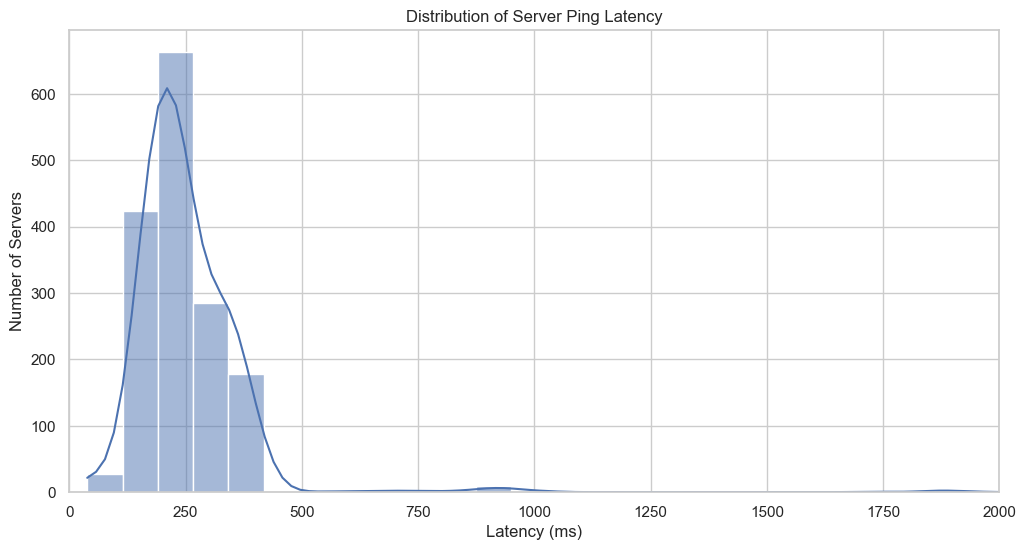

In [6]:
if not fingerprints_df.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(fingerprints_df['latency_ping'].dropna(), bins=50, kde=True)
    plt.title('Distribution of Server Ping Latency')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Number of Servers')
    plt.xlim(0, 2000) # Limit x-axis to a reasonable range
    plt.show()